In [1]:
from brainmri.core import MRIImage, img_paths, get_mask
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pickle

Loading Images


In [2]:
# mri_images = [MRIImage.from_file(path) for path in img_paths]
# pickle.dump(mri_images, open('mri_images.pkl', 'wb'))

In [3]:
from brainmri.core import DATA_PATH

mri_images = pickle.load(open(DATA_PATH / 'mris.pkl', 'rb'))

In [4]:
max_cs = []
gas = []
for mri_image in mri_images:
    pixel_size_mm = mri_image.zooms[-1]
    max_c = 0
    max_img = None

    for img in mri_image.slices_z[20:-20]:
        mask = img == 0
        coords=np.array(np.nonzero(~mask))
        if coords.size == 0:
            continue
        bottom_y, bottom_x = np.max(coords, axis=1)
        top_y, top_x = np.min(coords, axis=1)
        a = (bottom_y - top_y) * pixel_size_mm
        b = (bottom_x - top_x) * pixel_size_mm
        cirum_eq = 1.62 * (a+b) / 10

        img = get_mask(img)
        img = np.array(img, dtype=np.uint8)
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

        contours, hierarchy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        blank_img = np.zeros_like(img)
        img_with_contours = cv.drawContours(blank_img, contours, -1, 255, 1)

        circum_im = sum(img_with_contours.flatten() == 255) * pixel_size_mm / 10

        avg = (cirum_eq + circum_im) / 2
        if avg > max_c:
            max_c = avg 
            max_img = img
        #print(cirum_eq, circum_im)
            
    max_cs.append(max_c)
    gas.append(mri_image.ga)

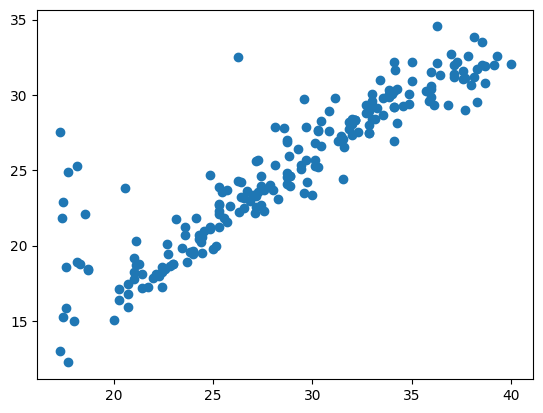

In [5]:
gas = np.array(gas)
max_cs = np.array(max_cs)

gas_f = []
max_cs_f = []

for g, m in zip(gas, max_cs):
    if g and g > 0:
        gas_f.append(g)
        max_cs_f.append(m)

plt.scatter(gas_f, max_cs_f)
plt.show()